### Import/Install Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
import sklearn.metrics
import xgboost as xgb

In [ ]:
# config
seed = 563

### Objective

### Read data/ data summary

In [ ]:
data = pd.read_csv('./Titanic-Dataset.csv')
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
data['Survived'].value_counts() #class imbalance?

Survived
0    549
1    342
Name: count, dtype: int64

### Data Preprocessing

In [ ]:
#duplicate, fillna/dropna, normalize, split, one-hot-encoding

In [ ]:
data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [ ]:
embarked = pd.get_dummies(data['Embarked'])

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
norm = pd.DataFrame(scaler.fit_transform(data[['Age', 'Fare']]), data.index, columns=['norm_Age', 'norm_Fare'])

In [ ]:
data = pd.concat([data.drop(columns=['Embarked', 'Age', 'Fare']), embarked, norm], axis=1)
data['norm_Age'] = data['norm_Age'].fillna(data['norm_Age'].median())
data['Sex'] = np.vectorize(lambda x: True if x == 'male' else False)(data['Sex'])
data.set_index(['PassengerId'], inplace=True)
data.sort_index(inplace=True)
data

,Survived,Pclass,Sex,SibSp,Parch,C,Q,S,norm_Age,norm_Fare
PassengerId,,,,,,,,,,
1,0,3,True,1,0,False,False,True,-0.457653,-0.971698
2,1,1,False,1,0,True,False,False,-0.055542,-0.721729
3,1,3,False,0,0,False,False,True,-0.357125,-0.969063
4,1,1,False,1,0,False,False,True,-0.130937,-0.792711
5,0,3,True,0,0,False,False,True,-0.130937,-0.968575
...,...,...,...,...,...,...,...,...,...,...
887,0,2,True,0,0,False,False,True,-0.331993,-0.949251
888,1,1,False,0,0,False,False,True,-0.533049,-0.882888
889,0,3,False,1,2,False,False,True,-0.306861,-0.908457


In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    bool   
 3   SibSp      891 non-null    int64  
 4   Parch      891 non-null    int64  
 5   C          891 non-null    bool   
 6   Q          891 non-null    bool   
 7   S          891 non-null    bool   
 8   norm_Age   891 non-null    float64
 9   norm_Fare  891 non-null    float64
dtypes: bool(4), float64(2), int64(4)
memory usage: 52.2 KB


In [ ]:
y = data['Survived']
X = data.drop(columns=['Survived'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### Classification Model 1 - SVM?

In [ ]:
# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# # Feature Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create the SVM model
svm_model = SVC(kernel='linear', random_state=seed)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7877094972067039


### Classification Model 2 - RandomForest/Gradient Tree Boosting?

In [ ]:
params = {
  'n_estimators': [100, 1000],
  'learning_rate':  [0.01, 0.1, 0.05],
  'max_depth': [4, 5, 6],
  'colsample_bytree':[0.8, 1],
#   'gamma':[0],
  # 'scale_pos_weight':[scale],
}

gbc = xgb.XGBClassifier(
    # tree_method='auto', device = "cuda",
    random_state=seed,
    early_stopping_rounds=42,
    eval_metric='error',
    objective='binary:logistic',
)

k_fold = KFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=params,
    scoring='accuracy',
    cv = k_fold,
    verbose=1,
    n_jobs=4,
)

grid_search.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    #sample_weight=sample_weights,
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0]	validation_0-error:0.46369
[1]	validation_0-error:0.46369
[2]	validation_0-error:0.46369
[3]	validation_0-error:0.46369
[4]	validation_0-error:0.46369
[0]	validation_0-error:0.46369
[5]	validation_0-error:0.46369
[1]	validation_0-error:0.46369
[0]	validation_0-error:0.46369
[6]	validation_0-error:0.46369
[2]	validation_0-error:0.46369
[1]	validation_0-error:0.46369
[3]	validation_0-error:0.46369
[7]	validation_0-error:0.46369
[4]	validation_0-error:0.46369
[2]	validation_0-error:0.46369
[3]	validation_0-error:0.46369
[5]	validation_0-error:0.46369
[8]	validation_0-error:0.46369
[0]	validation_0-error:0.46369[6]	validation_0-error:0.46369

[7]	validation_0-error:0.46369
[4]	validation_0-error:0.46369
[9]	validation_0-error:0.46369
[1]	validation_0-error:0.46369
[2]	validation_0-error:0.46369
[10]	validation_0-error:0.46369
[8]	validation_0-error:0.46369
[5]	validation_0-error:0.46369
[11]	validation_0-error:0.46369
[9]	va

GridSearchCV(cv=KFold(n_splits=5, random_state=563, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=42,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=563, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [4, 5, 6], 'n_estimators': [100, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best Parameters are",best_params)


ins_accuracy = sklearn.metrics.accuracy_score(y_train, best_model.predict(X_train))
ins_conf_mat = sklearn.metrics.confusion_matrix(y_train, best_model.predict(X_train), normalize='all')

print(f"In-sample Accuracy: {ins_accuracy:.4f}")
print(f"In-sample Confusion_matrix:\n{ins_conf_mat}")

y_pred = best_model.predict(X_test)
oos_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
oos_conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='all')

print(f"Out-of-sample Accuracy: {oos_accuracy:.4f}")
print(f"Out-of-sample Confusion_matrix:\n{oos_conf_mat}")


The best Parameters are {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
In-sample Accuracy: 0.8806
In-sample Confusion_matrix:
[[0.61235955 0.0238764 ]
 [0.09550562 0.26825843]]
Out-of-sample Accuracy: 0.8212
Out-of-sample Confusion_matrix:
[[0.51396648 0.02234637]
 [0.15642458 0.30726257]]


### Tree

In [ ]:
# Pick 5-fold Cross Validation

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini'],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], # 8
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], # 7
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], # 2
    'max_features': [None],
    'splitter': ['best']
}

# Instantiate the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=seed)


print('5- fold cross validation:')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new DecisionTreeClassifier with the best hyperparameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred_dt = best_dt.predict(X_train)
accuracy_train_dt = sklearn.metrics.accuracy_score(y_train, y_train_pred_dt)
print("Accuracy on Training Set: {:.2f}".format(accuracy_train_dt * 100))

# Evaluate the model on the test set
y_test_pred_dt = best_dt.predict(X_test)
accuracy_test_dt = sklearn.metrics.accuracy_score(y_test, y_test_pred_dt)
print("Accuracy on Test Set: {:.2f}".format(accuracy_test_dt * 100))


5- fold cross validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 87.08
Accuracy on Test Set: 78.77


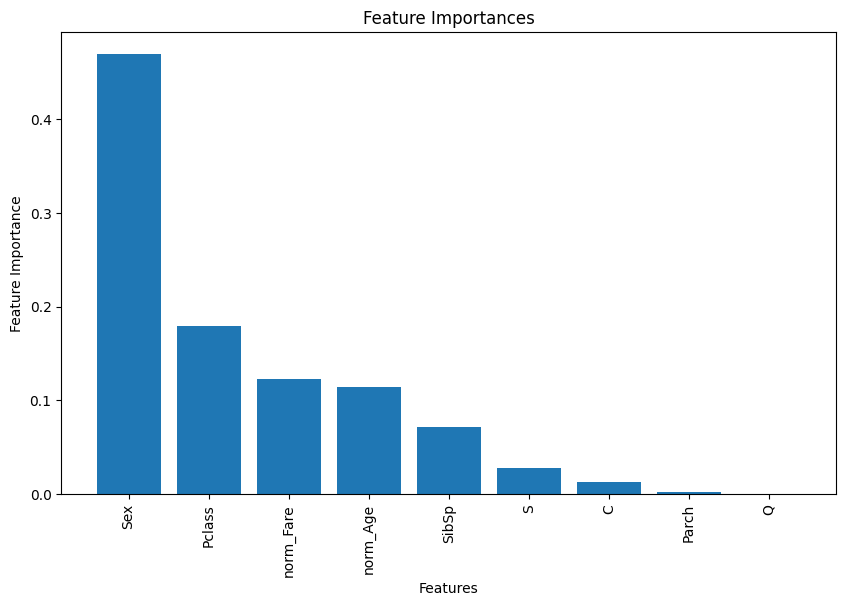

In [ ]:
# Get feature importances from the trained model
feature_importances = best_dt.feature_importances_

# Get the names of features
feature_names = X.columns  # Assuming X is your feature matrix, and you have column names

# Sort indices of feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Result/Analysis/Visualization

In [ ]:
4-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Accuracy on Training Set: 86.68
Accuracy on Test Set: 78.36

5-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 83.15
Accuracy on Test Set: 80.97

6-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 87.96
Accuracy on Test Set: 82.46

7-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 83.15
Accuracy on Test Set: 80.97

8-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 83.15
Accuracy on Test Set: 80.97

9-fold cross-validation:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on Training Set: 83.15
Accuracy on Test Set: 80.97